In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [88]:
# Membaca dan melihat data CSV

df_ecommerce_customer_churn = pd.read_csv('data_ecommerce_customer_churn.csv')
df_ecommerce_customer_churn.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


Data Analysist

In [89]:
# Memahami data menggunakan .info() untuk melihat tipe data setiap kolom
# Melihat apakah ada kolom yang tidak sesuai tipe datanya

df_ecommerce_customer_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


In [90]:
# Melihat apakah ada data Null atau N/A

print(f'Cek apakah ada data yang N/A: \n{df_ecommerce_customer_churn.isna().sum()}\n')

Cek apakah ada data yang N/A: 
Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64



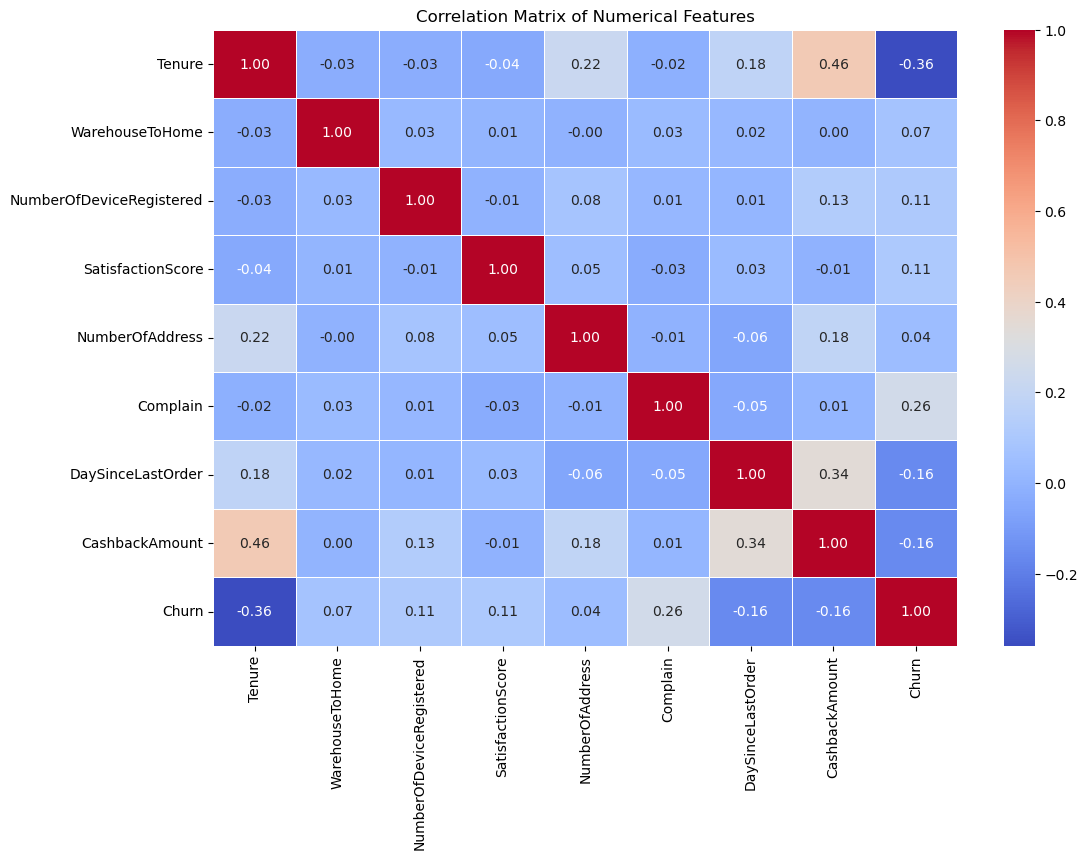

In [91]:
# Melakukan Feature Selection melalui korelasi antar fitur numerik

numerical_columns = df_ecommerce_customer_churn.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

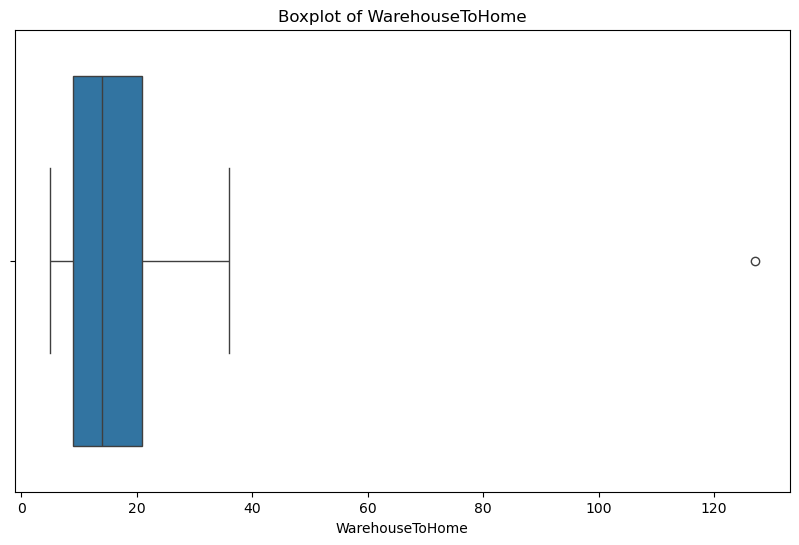

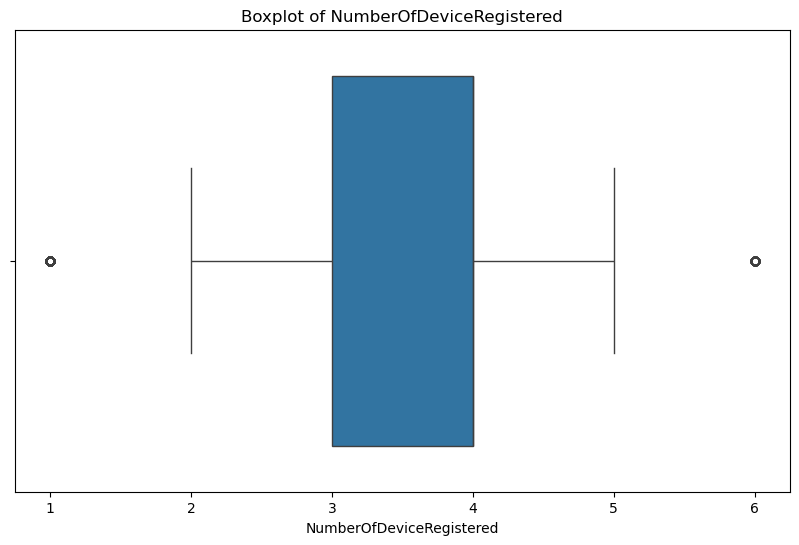

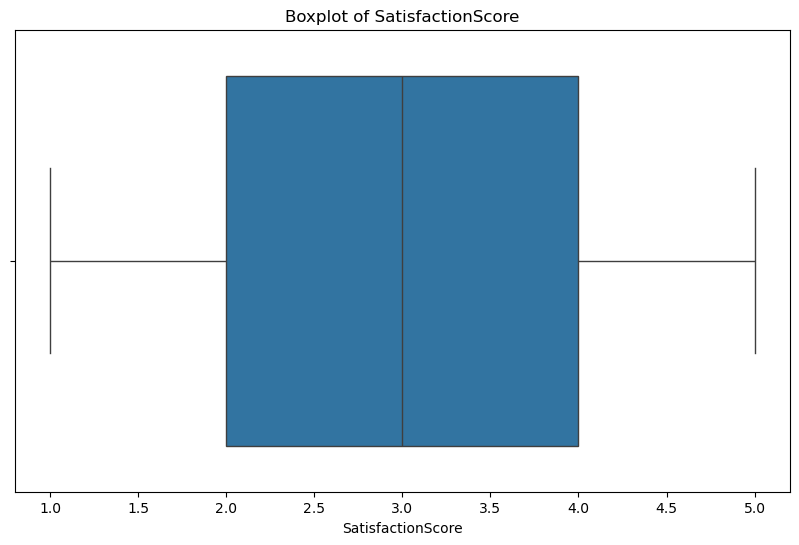

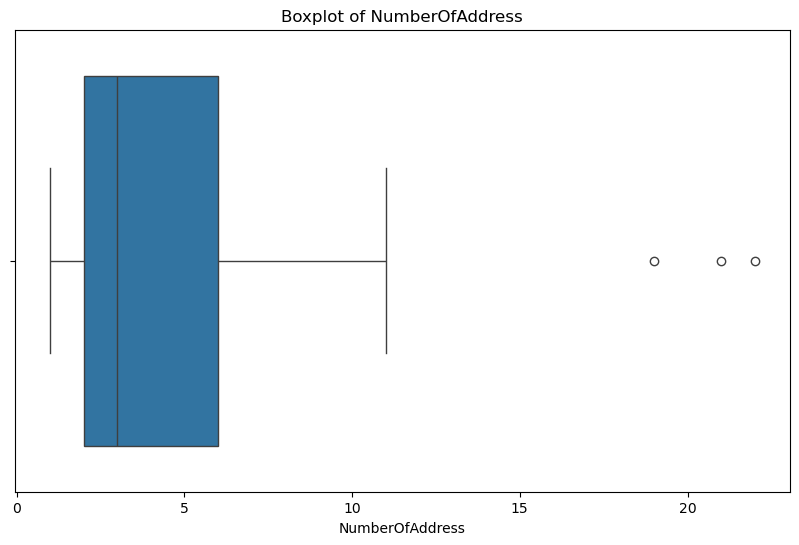

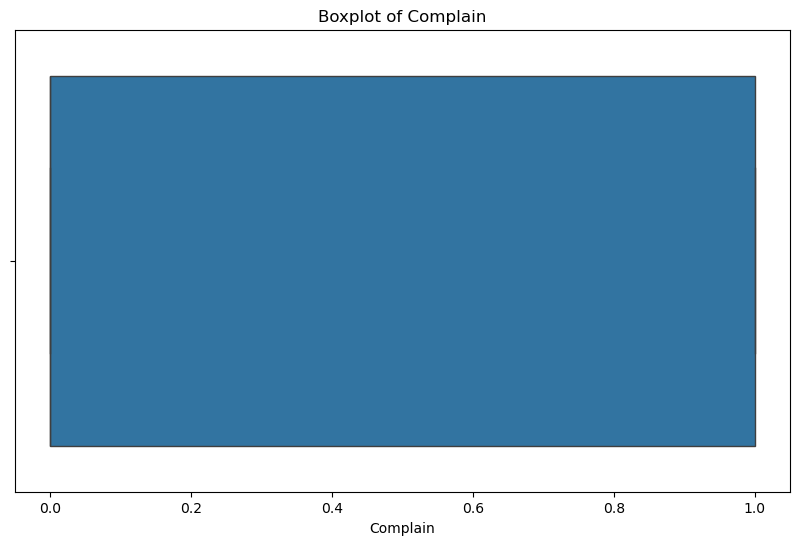

In [92]:
# Melihat kolom yang outlier
# Untuk menentukan apakah menggunakan Mean atau Median ketika melakukan Imputasi
# Kalau ada data outlier sebaiknya menggunakan Median supaya tidak terpengaruh dengan data yang outlier
# Karena kalau Mean akan terpengaruh dengan outlier 

# Beberapa kolom numerik diremove setelah melakukan Feature Selection
# Kolom yang diremove adalah: 'Tenure', 'DaySinceLastOrder', 'CashbackAmount'
numeric_features = ['WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain']
categorical_features = ['PreferedOrderCat', 'MaritalStatus']

for column in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_ecommerce_customer_churn[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

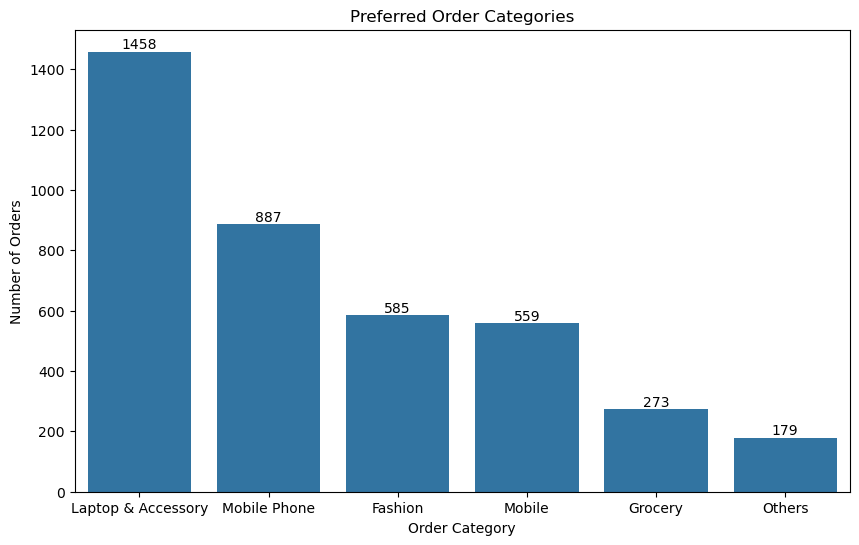

In [93]:
# Melihat distribusi data pada kolom Categories
# Diurutkan dari yang paling sering diorder ke paling yang tidak sering diorder

plt.figure(figsize=(10, 6))

preferred_order_categories_barplot = sns.barplot(
    data=df_ecommerce_customer_churn['PreferedOrderCat'].value_counts(),
)

for container in preferred_order_categories_barplot.containers:
    preferred_order_categories_barplot.bar_label(container, fmt='%.0f')

plt.title('Preferred Order Categories')
plt.xlabel('Order Category')
plt.ylabel('Number of Orders')
plt.show()

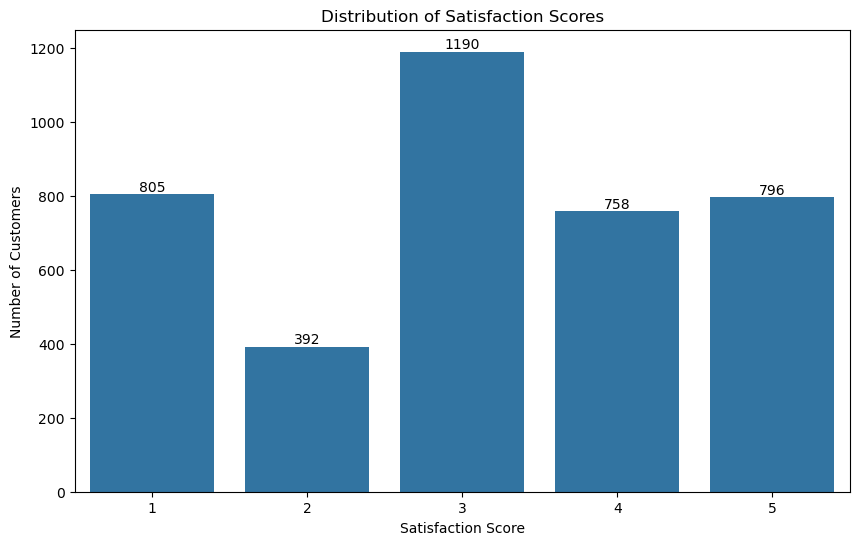

In [94]:
# Melihat distribusi data pada kolom Satifaction Score
# Ingin mengetahui berapa banyak customer memberikan nilai kepuasan

plt.figure(figsize=(10, 6))

distribution_satisfaction_scores_barplot = sns.barplot(
    data=df_ecommerce_customer_churn['SatisfactionScore'].value_counts(),
)

for container in distribution_satisfaction_scores_barplot.containers:
    distribution_satisfaction_scores_barplot.bar_label(container, fmt='%.0f')

plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Number of Customers')
plt.show()

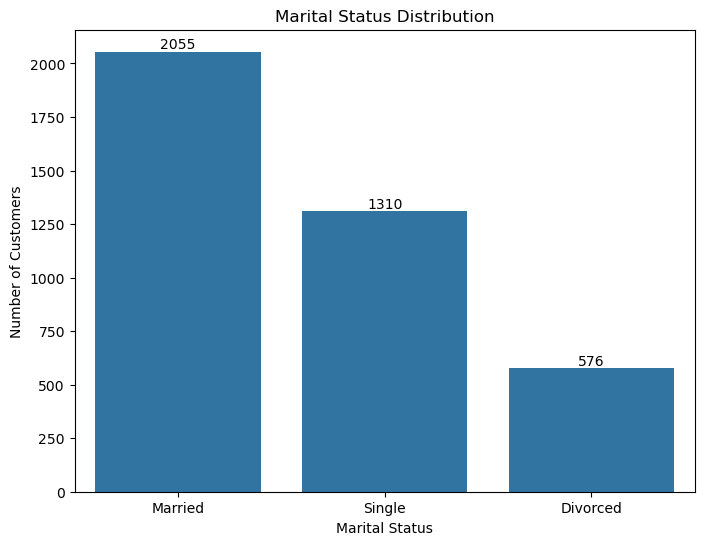

In [95]:
# Melihat distribusi data pada kolom Marital Status
# Diurutkan dari Marital Status yang paling banyak ke paling rendah

plt.figure(figsize=(8, 6))

marital_status_distribution_barplot = sns.barplot(
    data=df_ecommerce_customer_churn['MaritalStatus'].value_counts()
)

for container in marital_status_distribution_barplot.containers:
    marital_status_distribution_barplot.bar_label(container, fmt='%.0f')

plt.title('Marital Status Distribution')
plt.xlabel('Marital Status')
plt.ylabel('Number of Customers')
plt.show()

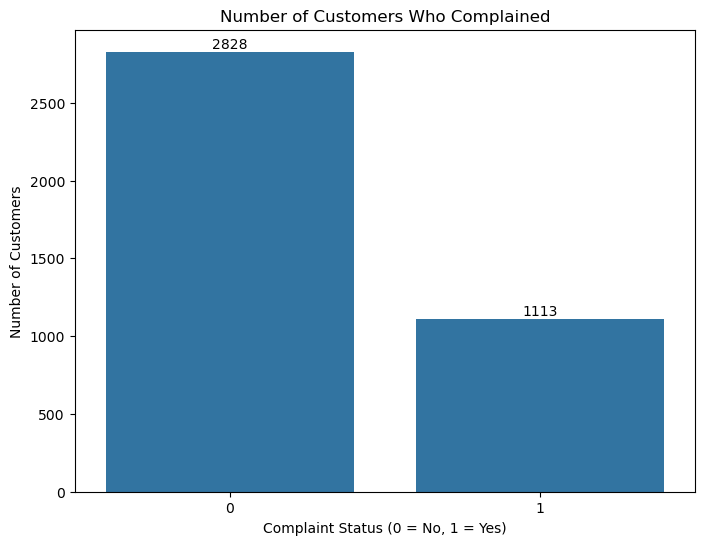

In [96]:
# Melihat distribusi data pada kolom Complaint
# Ingin mengetahui berapa banyak customer yang melakukan komplain dan yang tidak

plt.figure(figsize=(8, 6))

customer_complaint_distribution_barplot = sns.barplot(
    data=df_ecommerce_customer_churn['Complain'].value_counts()
)

for container in customer_complaint_distribution_barplot.containers:
    customer_complaint_distribution_barplot.bar_label(container, fmt='%.0f')

plt.title('Number of Customers Who Complained')
plt.xlabel('Complaint Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.show()

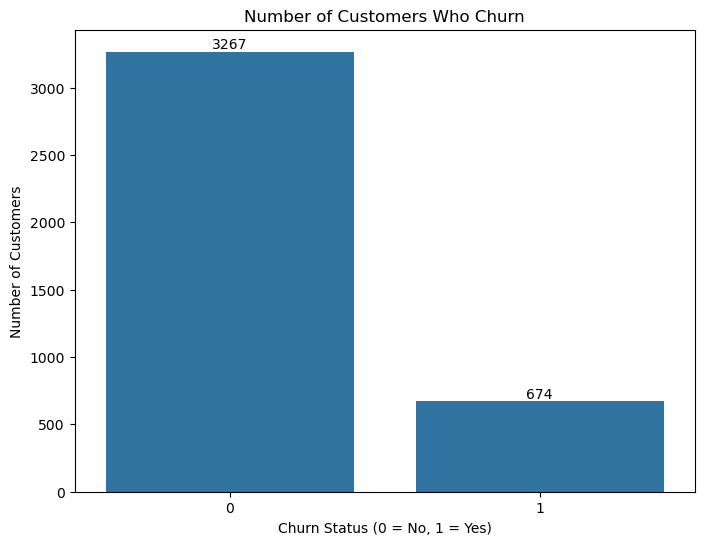

In [97]:
# Melihat distribusi data pada kolom Churn
# Ingin melihat berapa banyak customer yang Churn

plt.figure(figsize=(8, 6))

customer_churn_distribution_barplot = sns.barplot(
    data=df_ecommerce_customer_churn['Churn'].value_counts()
)

for container in customer_churn_distribution_barplot.containers:
    customer_churn_distribution_barplot.bar_label(container, fmt='%.0f')

plt.title('Number of Customers Who Churn')
plt.xlabel('Churn Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.show()

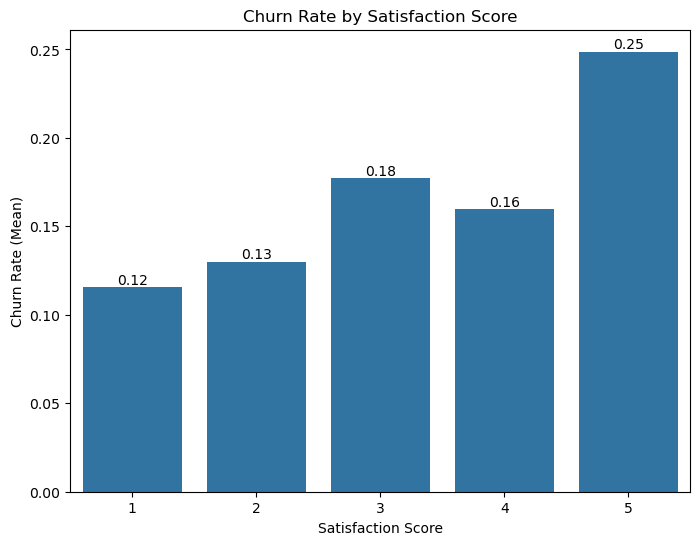

In [98]:
# Melihat berapa rata-rata orang yang Churn berdasarkan Satisfaction Score

plt.figure(figsize=(8, 6))

churn_rate_by_satisfaction_score_barplot = sns.barplot(
    data=df_ecommerce_customer_churn.groupby('SatisfactionScore')['Churn'].mean()
)

for container in churn_rate_by_satisfaction_score_barplot.containers:
    churn_rate_by_satisfaction_score_barplot.bar_label(container, fmt='%.2f')

plt.title('Churn Rate by Satisfaction Score')
plt.xlabel('Satisfaction Score')
plt.ylabel('Churn Rate (Mean)')
plt.show()

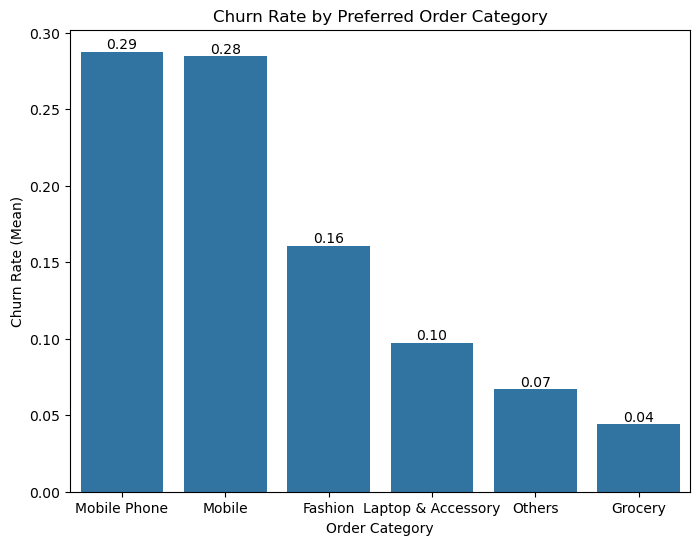

In [99]:
# Melihat berapa rata-rata orang yang Churn berdasarkan Category

plt.figure(figsize=(8, 6))

churn_rate_by_preferred_order_category_barplot = sns.barplot(
    data=df_ecommerce_customer_churn.groupby('PreferedOrderCat')['Churn'].mean().sort_values(ascending=False)
)

for container in churn_rate_by_preferred_order_category_barplot.containers:
    churn_rate_by_preferred_order_category_barplot.bar_label(container, fmt='%.2f')

plt.title('Churn Rate by Preferred Order Category')
plt.xlabel('Order Category')
plt.ylabel('Churn Rate (Mean)')
plt.show()

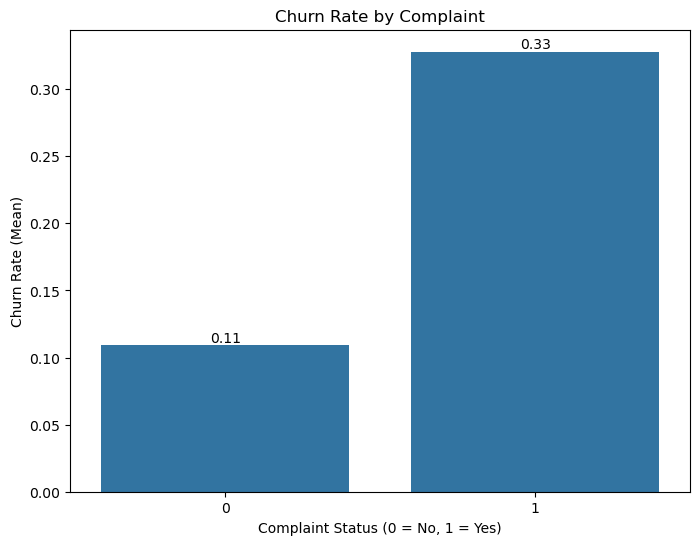

In [100]:
# Melihat berapa rata-rata orang yang Churn berdasarkan Complaint atau tidak

plt.figure(figsize=(8, 6))

churn_rate_by_complaint_status_barplot = sns.barplot(
    data=df_ecommerce_customer_churn.groupby('Complain')['Churn'].mean().sort_values(ascending=False)
)

for container in churn_rate_by_complaint_status_barplot.containers:
    churn_rate_by_complaint_status_barplot.bar_label(container, fmt='%.2f')

plt.title('Churn Rate by Complaint')
plt.xlabel('Complaint Status (0 = No, 1 = Yes)')
plt.ylabel('Churn Rate (Mean)')
plt.show()

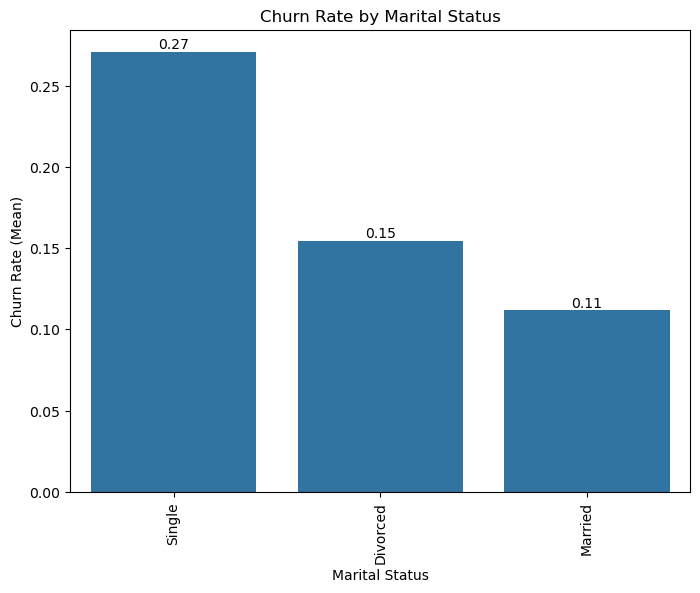

In [101]:
# Melihat berapa rata-rata orang yang Churn berdasarkan Marital Status
# Marital Status dibagi menjadi 10 group

plt.figure(figsize=(8, 6))

churn_rate_by_marital_status_barplot = sns.barplot(
    data=df_ecommerce_customer_churn.groupby('MaritalStatus')['Churn'].mean().sort_values(ascending=False)
)

for container in churn_rate_by_marital_status_barplot.containers:
    churn_rate_by_marital_status_barplot.bar_label(container, fmt='%.2f')

plt.title('Churn Rate by Marital Status')
plt.xlabel('Marital Status')
plt.xticks(rotation=90)
plt.ylabel('Churn Rate (Mean)')
plt.show()

Create Machine Learning Model

In [102]:
# Membuat pipeline untuk kolom numerik
# Pipeline berisi Imputer untuk mengisi data yang kosong dengan simple imputer 
# Dan mengubah data dengan simple scaler yang akan digunakan untuk pembuatan model machine learning

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [103]:
# Membuat pipeline untuk kolom kategorikal
# Pipeline berisi Imputer untuk mengisi data yang kosong
# Dan mengubah data kategorikal menjadi numerik menggunakan One Hot Encoder yang akan digunakan untuk pembuatan model machine learning

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False))
])

In [104]:
# Membuat preprocessor yang akan digunakan untuk mengisi dan mengubah data

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_features', numeric_transformer, numeric_features),
        ('categorical_features', categorical_transformer, categorical_features)
    ]
)

In [ ]:
# Membagi data untuk keperluan training dan testing

X = df_ecommerce_customer_churn.drop(columns=['Tenure', 'DaySinceLastOrder', 'CashbackAmount', 'Churn'])
y = df_ecommerce_customer_churn['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, stratify=y)

   WarehouseToHome  NumberOfDeviceRegistered    PreferedOrderCat  \
0             29.0                         4  Laptop & Accessory   
1             25.0                         4              Mobile   
2             13.0                         3  Laptop & Accessory   
3             25.0                         4             Fashion   
4             15.0                         4              Others   

   SatisfactionScore MaritalStatus  NumberOfAddress  Complain  
0                  3        Single                2         0  
1                  1       Married                2         0  
2                  1       Married                5         0  
3                  3      Divorced                7         0  
4                  4        Single                8         0  


In [106]:
# Membuat kumpulan model untuk membuat model machine learning
# Dengan ada param-param untuk Hyperparameter Tuning 

models = {
    'Logistic Regression': {
        'model': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(solver='liblinear'))
        ]),
        'params': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__class_weight': [None, 'balanced']
        }
    },
    'K-Nearest Neighbors': {
        'model': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', KNeighborsClassifier())
        ]),
        'params': {
            'classifier__n_neighbors': [3, 5, 7, 9],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__p': [1, 2]
        }
    },
    'Decision Tree': {
        'model': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(random_state=2020))
        ]),
        'params': {
            'classifier__max_depth': [3, 5, 10, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__class_weight': [None, 'balanced']
        }
    },
    'Random Forest': {
        'model': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(random_state=2020))
        ]),
        'params': {
            'classifier__n_estimators': [50, 100, 200, 300, 500],
            'classifier__max_depth': [None, 3, 5, 10, 20, 30, 50],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': [None, 'sqrt', 'log2']
        }
    }
}

In [107]:
# Melihat hasil cross-validation dari kumpulan model
# Untuk melihat model mana yamg memiliki score paling baik

cross_validation_result = []

for model_name, config in models.items():
    pipeline = config['model']
    cv_scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring=['accuracy'])
    cross_validation_result.append({
        'Model': model_name,
        'Mean Accuracy': cv_scores['test_accuracy'].mean()
    })

In [108]:
df_cross_validation_result = pd.DataFrame(cross_validation_result)
df_cross_validation_result

,Model,Mean Accuracy
0,Logistic Regression,0.853426
1,K-Nearest Neighbors,0.856605
2,Decision Tree,0.866756
3,Random Forest,0.885474


In [109]:
# Melakukan Training dan melakukan evaluasi model tanpa Hyperparameter Tuning
# Evaluasi model menggunakan Classification Report, ROC AUC, PR Score, dan Cross Validation Score
# Untuk melihat model machine learning mana yang paling akurat tanpa adanya Hyperparameter Tuning

for model_name, config in models.items():
    print(f"\nTraining without Tuning: {model_name}")
    pipeline = config['model']
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps['classifier'], 'predict_proba') else None

    # Matriks Evaluasi
    metrics_result = classification_report(y_true=y_test, y_pred=y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    pr_score = average_precision_score(y_test, y_prob) if y_prob is not None else 'N/A'

    print(f"Classification Report: \n {metrics_result}")
    print(f"ROC AUC: {roc_auc}")
    print(f"PR Score: {pr_score}")



Training without Tuning: Logistic Regression
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       654
           1       0.61      0.26      0.36       135

    accuracy                           0.85       789
   macro avg       0.74      0.61      0.64       789
weighted avg       0.82      0.85      0.82       789

ROC AUC: 0.8037886510363574
PR Score: 0.5101053191660686

Training without Tuning: K-Nearest Neighbors
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.95      0.91       654
           1       0.59      0.36      0.44       135

    accuracy                           0.85       789
   macro avg       0.73      0.65      0.68       789
weighted avg       0.83      0.85      0.83       789

ROC AUC: 0.8121078264809152
PR Score: 0.4691802651016044

Training without Tuning: Decision Tree
Classification Report: 
               precision  

In [112]:
# Melakukan Training dan melakukan evaluasi model dengan Hyperparameter Tuning
# Evaluasi model menggunakan Classification Report, ROC AUC, PR Score, dan Cross Validation Score
# Untuk melihat model machine learning mana yang paling akurat dengan adanya Hyperparameter Tuning

for model_name, config in models.items():
    print(f"\nTraining and Tuning: {model_name}")
    pipeline = config['model']
    
    grid_search = GridSearchCV(pipeline, config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters for {model_name}:")
    print(grid_search.best_params_)

    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1] if hasattr(grid_search.best_estimator_.named_steps['classifier'], 'predict_proba') else None

    # Matriks Evaluasi
    metrics_result = classification_report(y_true=y_test, y_pred=y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    pr_score = average_precision_score(y_test, y_prob) if y_prob is not None else 'N/A'

    print(f"Classification Report After Hyperparameter Tuning: \n {metrics_result}")
    print(f"ROC AUC: {roc_auc}")
    print(f"PR Score: {pr_score}")



Training and Tuning: Logistic Regression
Best Parameters for Logistic Regression:
{'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__penalty': 'l2'}
Classification Report After Hyperparameter Tuning: 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       654
           1       0.63      0.24      0.34       135

    accuracy                           0.85       789
   macro avg       0.74      0.60      0.63       789
weighted avg       0.82      0.85      0.82       789

ROC AUC: 0.8011835995016423
PR Score: 0.5042687505667207

Training and Tuning: K-Nearest Neighbors
Best Parameters for K-Nearest Neighbors:
{'classifier__n_neighbors': 9, 'classifier__p': 1, 'classifier__weights': 'distance'}
Classification Report After Hyperparameter Tuning: 
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       654
           1       0.76      0.47      0.58       135

    accu

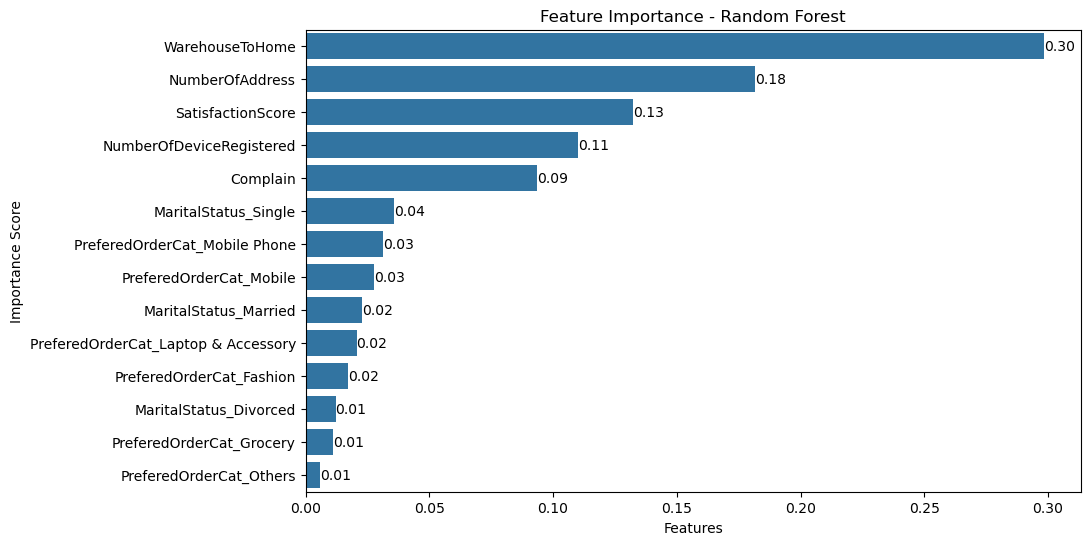

In [111]:
# Melihat Fitur mana saja yang paling berpengaruh terhadap model Random Forest menggunakan Feature Importance
# Fitur diurutkan dari yang paling berpengaruh ke yang paling tidak berpengaruh
# Kenapa menggunakan model Random Forest? Karena model Random Forest adalah model yang paling akurat dari semua model yang sudah di training 

X_train_preprocessed = models['Random Forest']['model']['preprocessor'].fit_transform(X_train)
X_test_preprocessed = models['Random Forest']['model']['preprocessor'].transform(X_test)


cat_feature_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(['PreferedOrderCat', 'MaritalStatus']).tolist()

all_feature_names = numeric_features + cat_feature_names

models['Random Forest']['model']['classifier'].fit(X_train_preprocessed, y_train)

feature_importance = pd.Series(models['Random Forest']['model']['classifier'].feature_importances_, index=all_feature_names)

feature_importance = feature_importance.sort_values(ascending=False)

df_feature_importance = pd.DataFrame(
    data=feature_importance.values,
    index=feature_importance.index
)

plt.figure(figsize=(10,6))
feature_importance_barplot = sns.barplot(
    data=df_feature_importance,
    x=df_feature_importance[0],
    y=df_feature_importance.index
)

for container in feature_importance_barplot.containers:
    feature_importance_barplot.bar_label(container, fmt='%.2f')

plt.title("Feature Importance - Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()